# Unit 9 Project -- Predicting a Player's PPG

In [235]:
import torch
import numpy as np
from torch import nn
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

This project aims to predict a basketball player's points per game (PPG) using a neural network. We will explore different models and input features to see how they impact the prediction accuracy. The dataset used contains various player statistics from the 2023-2024 basketball season. (Data from Mr. Arredondo's github)


In [242]:
url_p = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'
data = pd.read_csv(url_p)
data["PPG"] = data["PTS"] / data["G"]
data = data[["MP", "Age", "G","eFG%", "PPG"]] # important columns are change and the five factors
data

,MP,Age,G,eFG%,PPG
0,1624,24,74,0.529,7.635135
1,2416,26,71,0.529,19.253521
2,1641,23,78,0.483,5.833333
3,1618,23,61,0.528,10.721311
4,1921,25,82,0.560,7.987805
...,...,...,...,...,...
567,439,35,33,0.606,4.151515
568,1942,25,54,0.516,25.722222
569,545,25,48,0.552,4.625000
570,320,31,43,0.427,1.767442


# **Reasoning for Predictors:**

*   **G (Games Played):** Players who play more generally have more opportunities to score. This is expected to be a strong positive predictor of PPG. Additioanlly, players with lower PPGs will be benched more often as they don't contribute to the team well enough, lowering their play time.
*   **Age:** Player performance can vary with age. Younger players might be developing, while older players might be past their peak. The relationship might not be linear, with players around age 26-30 probably performing the best.
*   **eFG% (Effective Field Goal Percentage):** This metric accounts for the fact that a 3-point shot is worth more than a 2-point shot. A higher eFG% indicates more efficient scoring, which should lead to higher PPG.


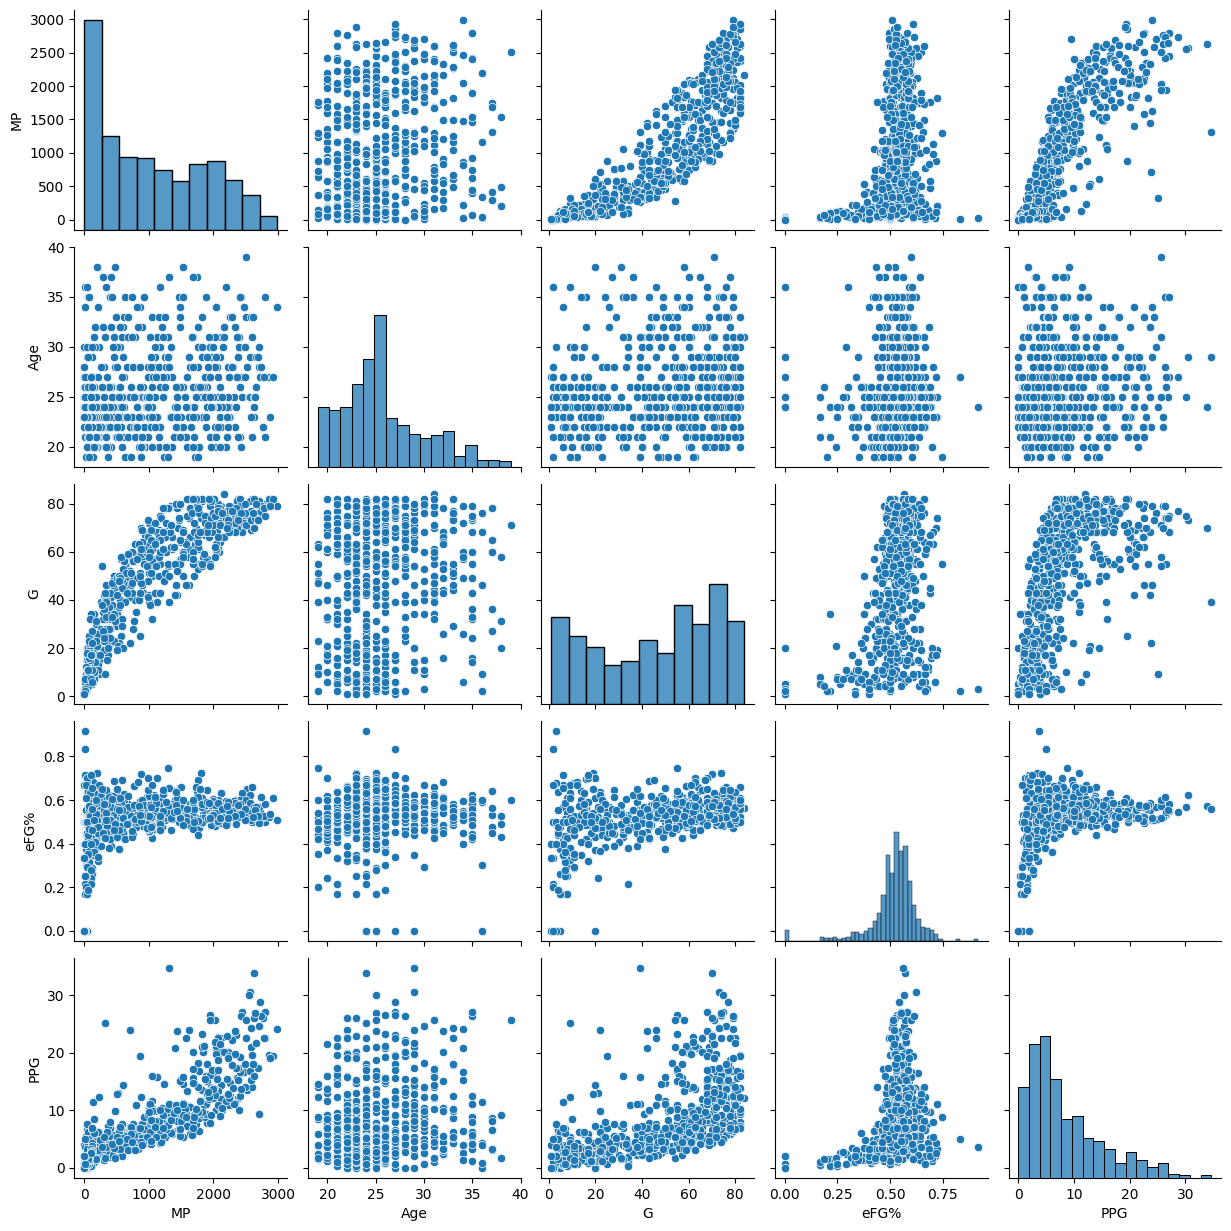

In [243]:
sns.pairplot(data)

In [244]:
#convert to numpy array
matrix = data.to_numpy()
#convert to a PyTorch tensor
tensor = torch.from_numpy(matrix)

print(tensor) #the default data type is a float
#the dimensions of our tensor/matrix--this will be of vital importance.
print(tensor.shape)

tensor([[1.6240e+03, 2.4000e+01, 7.4000e+01, 5.2900e-01, 7.6351e+00],
        [2.4160e+03, 2.6000e+01, 7.1000e+01, 5.2900e-01, 1.9254e+01],
        [1.6410e+03, 2.3000e+01, 7.8000e+01, 4.8300e-01, 5.8333e+00],
        ...,
        [5.4500e+02, 2.5000e+01, 4.8000e+01, 5.5200e-01, 4.6250e+00],
        [3.2000e+02, 3.1000e+01, 4.3000e+01, 4.2700e-01, 1.7674e+00],
        [1.7940e+03, 2.6000e+01, 6.8000e+01, 6.4900e-01, 1.1676e+01]],
       dtype=torch.float64)
torch.Size([572, 5])


In [249]:

#convert to a PyTorch tensor
ppg = data['PPG'].to_numpy()
pp = torch.from_numpy(ppg)
mp = data["G"].to_numpy()
m = torch.from_numpy(mp)

X = m.unsqueeze(dim=1) #use mkt as a predictor
y = pp.unsqueeze(dim=1)


# Scale the height using standardization
scaler = StandardScaler()
msc = scaler.fit_transform(
    m.reshape(-1, 1) #makes it a column vector
    )

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    msc, pp, test_size=0.2,
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

<ipython-input-249-0f072d4c5572>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
<ipython-input-249-0f072d4c5572>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [250]:
model_1 = nn.Sequential(
    #our input is a vector, so 1 diminsion.
    nn.Linear(in_features=1, out_features=32,),
    nn.RReLU(),

    #hidden layer with 32 nodes
    nn.Linear(in_features=32, out_features=16, ),
    nn.RReLU(),

    #moves to hidden layer with 16 nodes
    nn.Linear(in_features=16, out_features=8, ),
    nn.RReLU(),

    #hidden layer with 8 nodes
    nn.Linear(in_features=8, out_features=4, ),
    nn.RReLU(),

    #hidden layer with 4 nodes
    nn.Linear(in_features=4, out_features=1, ),
    #outputs a vector of predicted weights
)


In [251]:
loss_fn = nn.MSELoss()

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.0001) #this is how fast it optimizes; smaller is slower, but more consistent


In [252]:
X_train = X_train.float()
X_test = X_test.float()
y_train = y_train.float()
y_test = y_test.float()

# Ensure that the model's parameters are in the correct dtype (Float)
model_1 = model_1.float()


In [253]:
# Set the number of epochs; this is how many times we update our model
epochs = 50000

for epoch in range(epochs):
    ### Training

    #this allows our matrices to update
    model_1.train()

    # 1. Forward pass; makes predictions
    y_pred = model_1(X_train)

    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(y_pred.squeeze(), y_train)

    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()

    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()

    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()

    ### Testing
    model_1.eval() #forces our matrices to stay the same
    with torch.inference_mode():
      # 1. Forward pass; makes predictions, but with test data
      test_pred = model_1(X_test)
      # 2. Calculate the loss, but with test data
      test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 200 == 0: #prints every 200 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([115])) that is different to the input size (torch.Size([115, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 | Train loss: 112.41500, Test loss: 89.90303
Epoch: 200 | Train loss: 100.29476, Test loss: 79.71786
Epoch: 400 | Train loss: 62.86113, Test loss: 52.66534
Epoch: 600 | Train loss: 31.40613, Test loss: 50.05192
Epoch: 800 | Train loss: 30.82015, Test loss: 53.72715
Epoch: 1000 | Train loss: 30.84229, Test loss: 54.25158
Epoch: 1200 | Train loss: 30.85975, Test loss: 54.33272
Epoch: 1400 | Train loss: 30.88266, Test loss: 54.34206
Epoch: 1600 | Train loss: 30.87358, Test loss: 54.35670
Epoch: 1800 | Train loss: 30.85365, Test loss: 54.35345
Epoch: 2000 | Train loss: 30.93363, Test loss: 54.34993
Epoch: 2200 | Train loss: 30.83741, Test loss: 54.37203
Epoch: 2400 | Train loss: 30.91309, Test loss: 54.36852
Epoch: 2600 | Train loss: 30.85703, Test loss: 54.38082
Epoch: 2800 | Train loss: 30.90131, Test loss: 54.37915
Epoch: 3000 | Train loss: 30.93904, Test loss: 54.39444
Epoch: 3200 | Train loss: 30.90291, Test loss: 54.40118
Epoch: 3400 | Train loss: 30.89026, Test loss: 54.400

In [254]:
# Turn on evaluation mode
model_1.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_1(X_test)

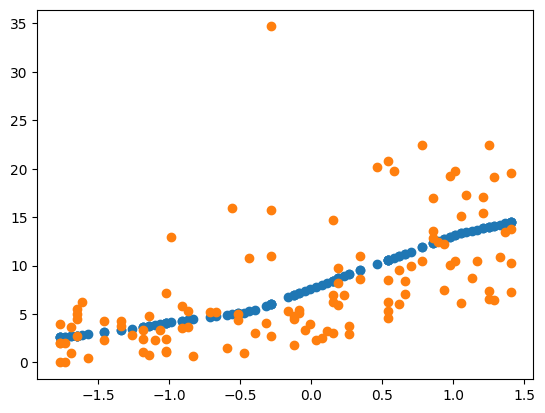

In [255]:
#plots predictions--remember, our model has never seen X_test
plt.scatter(X_test.detach().numpy(),y_preds.detach().numpy())

#plots test data
plt.scatter(X_test.detach().numpy(),y_test.detach().numpy())

Model 1 (RReLU Activation):

* Loss: The training and test loss values generally decrease over the epochs, indicating that the model is learning. However, the losses might fluctuate, and the model might not be perfectly capturing the  relationship.
* Scatter Plot: The scatter plot of predictions vs. actual values shows a trend, but the predictions might appear more linear or less able to capture non-linear patterns in the data, especially at the extremes of the 'Games Played' range. RReLU is a linear function for positive inputs, which can sometimes limit its ability to model complex, non-linear relationships.
* After 0.5 on the x-axis, the RReLU model really angled and not smooth at all.


In [256]:
model_15 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Tanh(),
    nn.Linear(in_features=10, out_features=10),
    nn.Tanh(),
    nn.Linear(in_features=10, out_features=5),
    nn.Tanh(),
    nn.Linear(in_features=5, out_features=1)
)

In [257]:
loss_fn = nn.MSELoss()

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=model_15.parameters(),
                            lr=0.0001) #this is how fast it optimizes; smaller is slower, but more consistent


In [258]:
X_train = X_train.float()
X_test = X_test.float()
y_train = y_train.float()
y_test = y_test.float()

# Ensure that the model's parameters are in the correct dtype (Float)
model_1 = model_15.float()


In [259]:
# Set the number of epochs; this is how many times we update our model
epochs = 50000

for epoch in range(epochs):
    ### Training

    #this allows our matrices to update
    model_15.train()

    # 1. Forward pass; makes predictions
    y_pred = model_15(X_train)

    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(y_pred.squeeze(), y_train)

    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()

    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()

    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()

    ### Testing
    model_15.eval() #forces our matrices to stay the same
    with torch.inference_mode():
      # 1. Forward pass; makes predictions, but with test data
      test_pred = model_15(X_test)
      # 2. Calculate the loss, but with test data
      test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 200 == 0: #prints every 200 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 128.26031, Test loss: 102.39936
Epoch: 200 | Train loss: 113.06423, Test loss: 89.69861
Epoch: 400 | Train loss: 98.79675, Test loss: 77.76701
Epoch: 600 | Train loss: 84.87931, Test loss: 66.16097
Epoch: 800 | Train loss: 73.29078, Test loss: 56.64601
Epoch: 1000 | Train loss: 64.64673, Test loss: 49.81147
Epoch: 1200 | Train loss: 58.49229, Test loss: 45.27470
Epoch: 1400 | Train loss: 54.09673, Test loss: 42.43336
Epoch: 1600 | Train loss: 50.77738, Test loss: 40.80953
Epoch: 1800 | Train loss: 47.94855, Test loss: 40.15415
Epoch: 2000 | Train loss: 45.24141, Test loss: 40.45443
Epoch: 2200 | Train loss: 42.80938, Test loss: 41.58377
Epoch: 2400 | Train loss: 40.94126, Test loss: 42.93922
Epoch: 2600 | Train loss: 39.57087, Test loss: 44.07660
Epoch: 2800 | Train loss: 38.53863, Test loss: 44.96975
Epoch: 3000 | Train loss: 37.73332, Test loss: 45.70744
Epoch: 3200 | Train loss: 37.08117, Test loss: 46.34759
Epoch: 3400 | Train loss: 36.53115, Test loss: 46.91

In [260]:
# Turn on evaluation mode
model_15.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_15(X_test)

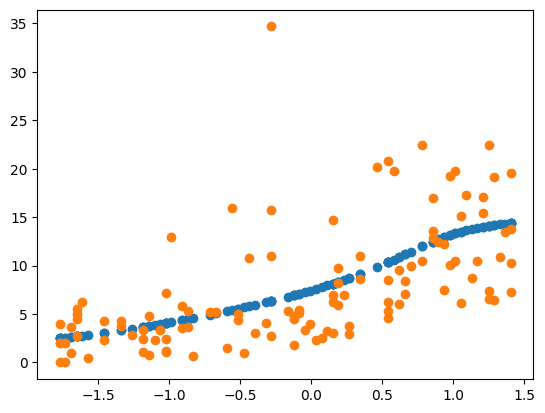

In [261]:
#plots predictions--remember, our model has never seen X_test
plt.scatter(X_test.detach().numpy(),y_preds.detach().numpy())

#plots test data
plt.scatter(X_test.detach().numpy(),y_test.detach().numpy())

Model 1.5 (Tanh Activation):

* Loss: The training and test loss values also decrease, and they might reach slightly lower values compared to Model 1. This would suggest a better fit to the data.
* Scatter Plot: The scatter plot for Model 1.5's predictions is slightly smoother, which probably models the relationship better.
* Lots of small bumps/curves, outlining the sort-of non-linear relationship.

In [262]:
predictor_cols = ["G", "Age", "eFG%"]
X_data = data[predictor_cols].to_numpy()

y_data = data["PPG"].to_numpy()

X = torch.from_numpy(X_data).float() # Convert to float32 immediately
y = torch.from_numpy(y_data).unsqueeze(dim=1).float() #y is also float32


# Scale the predictor data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.numpy()) # StandardScaler works on numpy arrays

    # Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y.numpy(), test_size=0.2, random_state=42 # Added random_state for reproducibility
    )

    # Convert splits back to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


All 3 predictors being used.

In [263]:
model_2 = nn.Sequential(
        #our input is a vector, so 1 diminsion. # This comment is no longer accurate
        nn.Linear(in_features=3, out_features=32,), # Changed in_features to 3
        nn.RReLU(),

        #hidden layer with 32 nodes
        nn.Linear(in_features=32, out_features=16, ),
        nn.RReLU(),

        #moves to hidden layer with 16 nodes
        nn.Linear(in_features=16, out_features=8, ),
        nn.RReLU(),

        #hidden layer with 8 nodes
        nn.Linear(in_features=8, out_features=4, ),
        nn.RReLU(),

        #hidden layer with 4 nodes
        nn.Linear(in_features=4, out_features=1, ),
        #outputs a vector of predicted weights
    )


In [264]:
loss_fn = nn.MSELoss()

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.0001) #this is how fast it optimizes; smaller is slower, but more consistent


In [265]:
X_train = X_train.float()
X_test = X_test.float()
y_train = y_train.float()
y_test = y_test.float()

# Ensure that the model's parameters are in the correct dtype (Float)
model_2 = model_2.float()


In [266]:
epochs = 50000

for epoch in range(epochs):
    ### Training

    #this allows our matrices to update
    model_2.train()

    # 1. Forward pass; makes predictions
    y_pred = model_2(X_train)

    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(y_pred.squeeze(), y_train)

    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()

    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()

    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()

    ### Testing
    model_2.eval() #forces our matrices to stay the same
    with torch.inference_mode():
      # 1. Forward pass; makes predictions, but with test data
      test_pred = model_2(X_test)
      # 2. Calculate the loss, but with test data
      test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 200 == 0: #prints every 200 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([457, 1])) that is different to the input size (torch.Size([457])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 | Train loss: nan, Test loss: nan
Epoch: 200 | Train loss: nan, Test loss: nan
Epoch: 400 | Train loss: nan, Test loss: nan
Epoch: 600 | Train loss: nan, Test loss: nan
Epoch: 800 | Train loss: nan, Test loss: nan
Epoch: 1000 | Train loss: nan, Test loss: nan
Epoch: 1200 | Train loss: nan, Test loss: nan
Epoch: 1400 | Train loss: nan, Test loss: nan
Epoch: 1600 | Train loss: nan, Test loss: nan
Epoch: 1800 | Train loss: nan, Test loss: nan
Epoch: 2000 | Train loss: nan, Test loss: nan
Epoch: 2200 | Train loss: nan, Test loss: nan
Epoch: 2400 | Train loss: nan, Test loss: nan
Epoch: 2600 | Train loss: nan, Test loss: nan
Epoch: 2800 | Train loss: nan, Test loss: nan
Epoch: 3000 | Train loss: nan, Test loss: nan
Epoch: 3200 | Train loss: nan, Test loss: nan
Epoch: 3400 | Train loss: nan, Test loss: nan
Epoch: 3600 | Train loss: nan, Test loss: nan
Epoch: 3800 | Train loss: nan, Test loss: nan
Epoch: 4000 | Train loss: nan, Test loss: nan
Epoch: 4200 | Train loss: nan, Test loss:

In [267]:
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test)


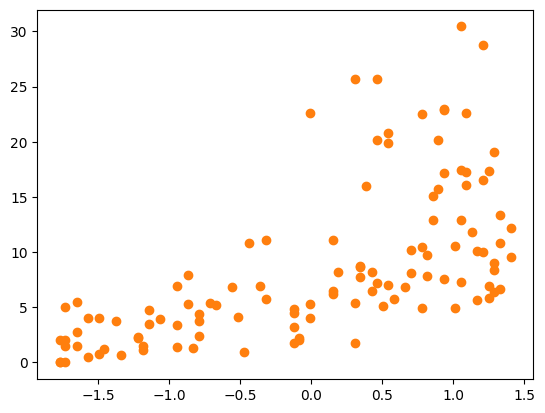

In [268]:
plt.scatter(X_test[:, 0].detach().numpy(), y_preds.detach().numpy())

#plots test data
plt.scatter(X_test[:, 0].detach().numpy(), y_test.detach().numpy())


Model 2:
* Test loss is a lot higher than Model 1 and 1.5, and the actual model doesnt even work. Maybe I inputted some things incorrectly in the build up, or the neural network got confused with the added predictors.
* I had high hopes for this, because I thought it'd be a nice build up from one predictor to 3, and everything would line up and finally look perfect, but I guess not.
* Straight up malfunctioned.

# Conclusion

We found that Model 1.5, which used a Tanh activation function and 'Games Played' as the sole predictor, performed best among the models tested, showing a lower test loss and visually capturing the potential non-linear relationship in the data more effectively than the RReLU-based single-predictor model (Model 1) or the multi-predictor model (Model 2). The unexpected higher test loss of Model 2, despite having more predictors, suggests that simply adding features does not guarantee improved performance and could actually just break your code.

